# Article length statistics

Some newspapers are not scrapeable and need to be excluded. This is detectable via article length statistics.

## Important newspapers

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from protest_impact.data.news.config import (
    local_newspapers,
    newspapers_of_record,
    popular_newspapers,
)
from protest_impact.util import project_root
from tqdm import tqdm

random.seed(20230126)
newspapers = newspapers_of_record + popular_newspapers + local_newspapers

df_path = project_root / "data" / "news" / "article_lengths.csv"

if df_path.exists():
    df_main = pd.read_csv(df_path)
else:
    lengths = []
    for newspaper in tqdm(newspapers):
        path = project_root / "data" / "news" / "fulltext" / newspaper
        if path.exists():
            # get distribution of article lengths
            files = random.sample(list(path.glob("*/*.txt")), 1000)
            for file in files:
                with open(file) as f:
                    text = f.read()
                lengths.append({"newspaper": newspaper, "length": len(text)})
    df_main = pd.DataFrame(lengths)
    df_main.to_csv(df_path, index=False)

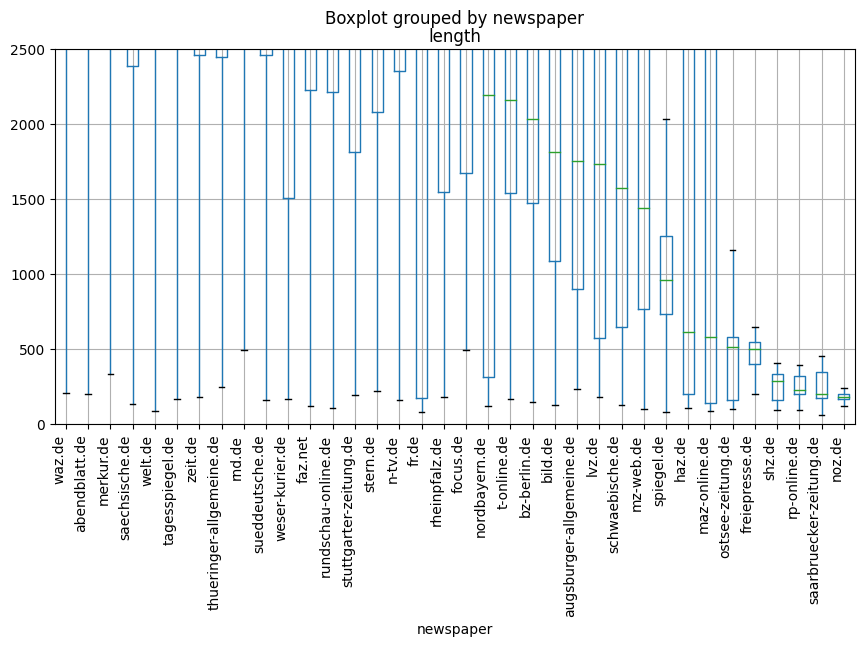

In [2]:
df = df_main.copy()
# plot distribution by newspaper (sorted by median length)
newspaper_order = (
    df.groupby("newspaper").median().sort_values("length", ascending=False).index
)
# sort by newspaper order
df["newspaper"] = pd.Categorical(df["newspaper"], categories=newspaper_order)
# plot
fig, ax = plt.subplots(figsize=(10, 5))
# do not plot outliers
df.boxplot(column="length", by="newspaper", ax=ax, showfliers=False)
# rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
# set y limits
ax.set_ylim(0, 2500)
plt.show()

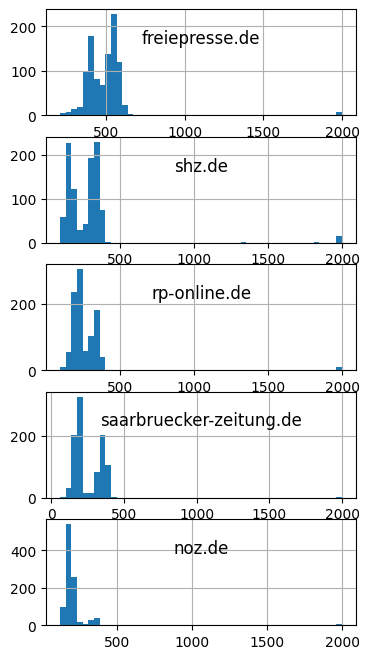

In [3]:
df = df_main.copy()
# cap at 2000 characters
df["length"] = df["length"].clip(upper=2000)
# plot histogram for each newspaper
n = 5
fig, axs = plt.subplots(n, 1, figsize=(4, 8))
for i, newspaper in enumerate(newspaper_order[-n:]):
    df[df["newspaper"] == newspaper]["length"].hist(ax=axs[i], bins=50)
    axs[i].set_title(newspaper, y=0.6)
plt.show()

## Mediacloud regional newspapers

In [4]:
from os import environ

from dotenv import load_dotenv
from protest_impact.types import NewsItem
from protest_impact.util.cache import get

load_dotenv()


def get_article_sample(media_id):
    response = get(
        "https://api.mediacloud.org/api/v2/stories_public/list/",
        params={
            "fq": f"media_id:{media_id}",
            "rows": "100",  # max 1000
            "order": "random",
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"},
    )
    results = response.json()
    return [NewsItem.from_dict(result) for result in results]

In [5]:
import json
from time import sleep

import pandas as pd
from protest_impact.data.news.config import filter_words, media_ids
from protest_impact.data.news.scraping import get_fulltext
from protest_impact.util import project_root
from tqdm.notebook import tqdm

with open(project_root / "data" / "news" / "german_newspapers.json") as f:
    german_newspapers = json.load(f)

print(len(german_newspapers))

lengths = []
for i, newspaper in enumerate(german_newspapers):
    print(i, newspaper["name"])
    sample = get_article_sample(newspaper["media_id"])
    for i, article in enumerate(sample):
        if not any(word in article.url for word in filter_words):
            try:
                article = get_fulltext(article)
                lengths.append(
                    {"newspaper": newspaper["name"], "length": len(article.content)}
                )
            except:
                sleep(5)
                continue
df_lengths = pd.DataFrame(lengths)

134
0 hna
1 tz.de
2 merkur-online
3 Christ & Welt: ZEIT für Glaube, Geist und Gesellschaft
4 wn.de
5 Lokales und Nachrichten Ahlen - Westfälische Nachrichten ...
6 augsburger-allgemeine.de
7 kreiszeitung.de
8 op-online.de
9 echo-online.de
10 Bergsträßer Anzeiger
11 Schwetzinger Zeitung / Hockenheimer Zeitung
12 noz.de
13 mutig - offen - mittendrin -
14 Delmenhorster Kreisblatt
15 Hauptsache Heimat. -
16 AbendBlatt
17 Bersenbrücker Kreisblatt
18 Hier zu Hause -
19 Region Dillenburg - mittelhessen.de
20 Lokales - mittelhessen.de
21 Lokale Nachrichten aus Bürstadt, Lampertheim, Rhein-Neckar und Hessen - Bürstädter Zeitung
22 Lokale Nachrichten aus Wiesbaden, Rheingau, Taunus und Hessen - Wiesbadener Kurier
23 rga-online
24 nordbayern.de
25 Oberpfalznetz
26 Nachrichten aus Amberg - Onetz
27 Lokale Nachrichten aus Worms, Rhein-Neckar, dem Wonnegau und Rheinland-Pfalz - Wormser Zeitung
28 page - Solinger Tageblatt
29 Nachrichten aus Weiden - Onetz
30 Salzgitter Zeitung - Salzgitter Zeitung
3

In [9]:
df_lengths.head()

,newspaper,length
0,hna,2226
1,hna,1696
2,hna,1838
3,hna,2332
4,hna,1548


In [11]:
import matplotlib.pyplot as plt

n = len(german_newspapers)
scrapable_newspapers = []
# plot histogram for each newspaper
# fig, axs = plt.subplots(len(german_newspapers[:n]), 1, figsize=(4, len(german_newspapers[:n])), sharex=True)
for i, newspaper in enumerate(german_newspapers[:n]):
    df = df_lengths[df_lengths["newspaper"] == newspaper["name"]]["length"]
    # get share of articles with length <= 500
    short_articles = df[df <= 1000].count() / df.count()
    # get variance of lengths
    filter_ = short_articles < 0.5 and df.std() > 1000
    if filter_:
        scrapable_newspapers.append(newspaper)
#     df.clip(upper=5000).hist(ax=axs[i], bins=50)
#     axs[i].set_title(f'{"✓" if filter_ else "✗"} {newspaper["name"]}')
# plt.tight_layout(pad=1.0)
# plt.show()

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_12050/2548121748.py:9: RuntimeWarning: invalid value encountered in long_scalars
  short_articles = df[df <= 1000].count() / df.count()


In [12]:
len(scrapable_newspapers)

57

In [15]:
with open(
    project_root / "data" / "news" / "scrapable_mediacloud_newspapers.json", "w"
) as f:
    json.dump(scrapable_newspapers, f)

In [19]:
from time import time

from protest_impact.data.news.config import media_ids
from protest_impact.data.news.download import get_protest_article_metadata
from protest_impact.data.protests.config import search_string

for i, newspaper in enumerate(scrapable_newspapers):
    print(i, newspaper["name"])
    articles = get_protest_article_metadata(newspaper["media_id"], time())
    print(len(articles))

0 hna
799
1 tz.de
9461
2 merkur-online
810
3 Christ & Welt: ZEIT für Glaube, Geist und Gesellschaft
7556
4 wn.de
21520
5 augsburger-allgemeine.de
5828
6 kreiszeitung.de
3855
7 op-online.de
9369
8 Oberpfalznetz
10760
9 Nachrichten aus Amberg - Onetz
10548
10 page - Solinger Tageblatt
2845
11 Nachrichten aus Weiden - Onetz
10700
12 Salzgitter Zeitung - Salzgitter Zeitung
5896
13 Wolfsburger Nachrichten - Wolfsburger Nachrichten
1
14 braunschweiger-zeitung.de
13196
15 mittelbayerische.de
22323
16 nw-news.de
2669
17 Startseite - Münstersche Zeitung
6091
18 http://www.wz.de/home


KeyboardInterrupt: 

In [ ]:
def get_protest_article_fulltexts(media_id, start_time, last_processed_stories_id=0):
    num_rows = 1000
    args = [
        "https://api.mediacloud.org/api/v2/stories_public/list/",
        params={
            "q": search_string[1:],
            "fq": f"media_id:{media_id}",
            "rows": num_rows, # max 1000
            "last_processed_stories_id": last_processed_stories_id,
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"}]
    if not get.check_call_in_cache(*args):
        return []
    response = get.check_call_in_cache(*args)
    result = response.json()
    articles = []
    for article in result:
        try:
            articles.append(get_fulltext(NewsItem.from_dict(article)))
        except:
            sleep(5)
            continue
    end_time = time()
    print(len(result), end_time - start_time)
    if len(result) > 0.9 * num_rows:
        last_processed_stories_id = result[-1]["processed_stories_id"]
        result += get_protest_article_metadata(media_id, end_time, last_processed_stories_id)
    return result

In [ ]:
for newspaper in scrapable_newspapers:
    print(newspaper["name"])
    articles = get_protest_article_metadata(newspaper["media_id"], time())
    print(len(articles))

In [ ]:
import random

import jsonlines

random.seed("20230127")
articles = random.sample(fulltexts, 500)

with jsonlines.open(
    project_root / "data" / "news" / "german_protest_articles.jsonl", "w"
) as writer:
    writer.write_all(
        {
            "text": f.title + "\n\n" + f.content,
            "meta": {"date": f.date.isoformat(), "url": f.url},
        }
        for f in fulltexts
    )